In [33]:
#%%timeit
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin

# sample properties
Vp = 3.10 # km/s
Diameter = 1*25.4 # mm
Length = (2.0)*25.4 # mm

# sensor locations polar coordinates (odd numbers are on top, and 
# even numbers are on bottom). z = 0 is experimentally fixed at top, 
# so depending on sample length difference from 2 inches, compensate with 'eps'
eps = Length/25.4 - 2
z = (2-np.array([0.4,1.2,0.8,1.6,0.4,1.2,0.8,1.6,0,2+eps])+eps)*25.4
radii = np.array([0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.25,0.25])*25.4
theta = np.array([0,0,270,270,180,180,90,90,205,0])
theta = np.deg2rad(theta)
# sensor locations in cartesian coordinates (mm)
Xi = radii*np.cos(theta)
Yi = radii*np.sin(theta)
Zi = z
# since sensors are not points, but areas, I will add a random
# offset dxi, dyi, dzi (between -0.1 and 0.1) to Xi, Yi, Zi
# note: only some sensors are affected

# uniaxial
# dx = np.concatenate((np.zeros(2),(rng.random((2,))-0.5)/5,np.zeros(2), 
#                   (rng.random((2,))-0.5)/5,(rng.random((2,))-0.5)/5), axis=None)
# dy = np.concatenate(((rng.random((2,))-0.5)/5,np.zeros(2),(rng.random((2,))-0.5)/5,
#                   np.zeros(2),(rng.random((2,))-0.5)/5), axis=None)
# dz = np.concatenate(((rng.random((8,))-0.5)/5,np.zeros(2)), axis=None)

# triaxial
# dx = np.concatenate(((rng.random((2,))-0.5)/5, np.zeros(2), (rng.random((2,))-0.5)/5, 
#                   np.zeros(2), (rng.random((2,))-0.5)/5), axis=None)
# dy = np.concatenate(((rng.random((2,))-0.5)/5, (rng.random((2,))-0.5)/5, np.zeros(2),
#                   (rng.random((2,))-0.5)/5, np.zeros(2)), axis=None)
# dz = np.concatenate((np.zeros(2), (rng.random((8,))-0.5)/5), axis=None)

# no inflence from sensor area
dx = np.zeros(10)
dy = np.zeros(10)
dz = np.zeros(10)

Xi+=dx
Yi+=dy
Zi+=dz
sensors = np.vstack((Xi,Yi,Zi)).T

# double check sensor locations in 3d
# from mpl_toolkits import mplot3d
# import matplotlib.pyplot as plt
# %matplotlib notebook
# fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax.scatter3D(Xi, Yi, Zi, c=azi)

# arrival time function (ev = event time and x,y,z positions, r = sensor locations, v = velocity of medium)
def atf(ev,r,v):
    result=[]
    for ri in r:
        result.append(np.sqrt((ev[1]-ri[0])**2+(ev[2]-ri[1])**2+(ev[3]-ri[2])**2)/v+ev[0]) 
    return np.array(result)
# error function (at = arrival times for each sensor)
def err(ev,r,v,at):
    result=((atf(ev,r,v)-at)**2).sum()
    return result

# arrival times: test data with known (random) solution
rng = np.random.default_rng()
r_test = rng.random((3,))
r_test[0] = (r_test[0] - 0.5)*(25.4)
r_test[1] = (r_test[1] - 0.5)*(25.4)
r_test[2] *= (25.4*2)
tt_norm = np.sqrt((Xi-r_test[0])**2+(Yi-r_test[1])**2+(Zi-r_test[2])**2)/Vp
picks = tt_norm - np.min(tt_norm)
# arrival times: real data
#picks = np.array([0.0166, 0.0074, 0.0074, 0.0094, 0.0086, 0.0088, -0.0008, 0.0204, 0.0126, 0.0092])
#picks *= 1e3
# initial guess located in the middle of sensors
ev0 = np.array([picks.min(),np.mean([np.min(Xi),np.max(Xi)]),np.mean([np.min(Yi),np.max(Yi)]),np.mean([np.min(Zi),np.max(Zi)])])
# Nelder Mead optimum search (Simplex Method)
event = fmin(err,ev0,args=(sensors,Vp,picks),disp=False,full_output=True)
print(event)
if (event[0][1]**2 + event[0][2]**2) <= Diameter**2/4:
    if event[0][3] >= np.min(Zi) and event[0][3] <= np.max(Zi):
            print(f'\nx_test [mm] = {round(r_test[0],2)}; y_E [mm] = {round(r_test[1],2)}; z_E [mm] = {round(r_test[2],2)}')
            print(f'\nx_E [mm] = {round(event[0][1],2)}; y_E [mm] = {round(event[0][2],2)}; z_E [mm] = {round(event[0][3],2)}; t_E [ms] = {round(event[0][0],3)}')

(array([-3.55557174, -5.12467222, -8.00085362, 20.3579109 ]), 6.172719919380665e-06, 474, 801, 1)

x_test [mm] = -5.12; y_E [mm] = -8.0; z_E [mm] = 20.36

x_E [mm] = -5.12; y_E [mm] = -8.0; z_E [mm] = 20.36; t_E [ms] = -3.556


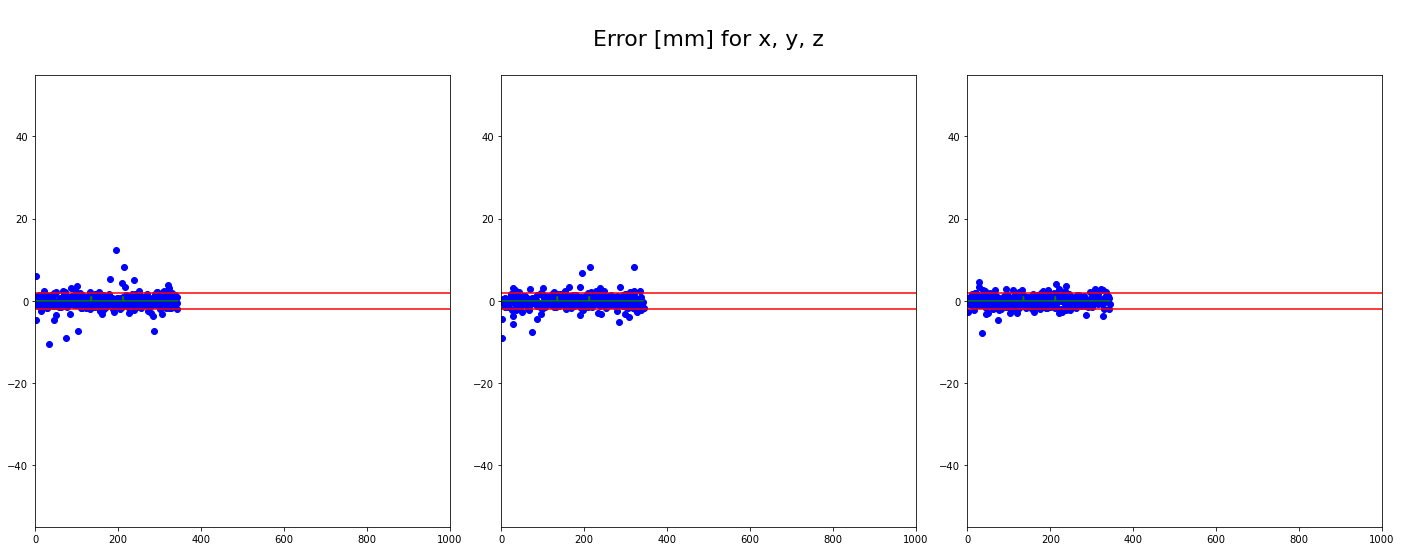

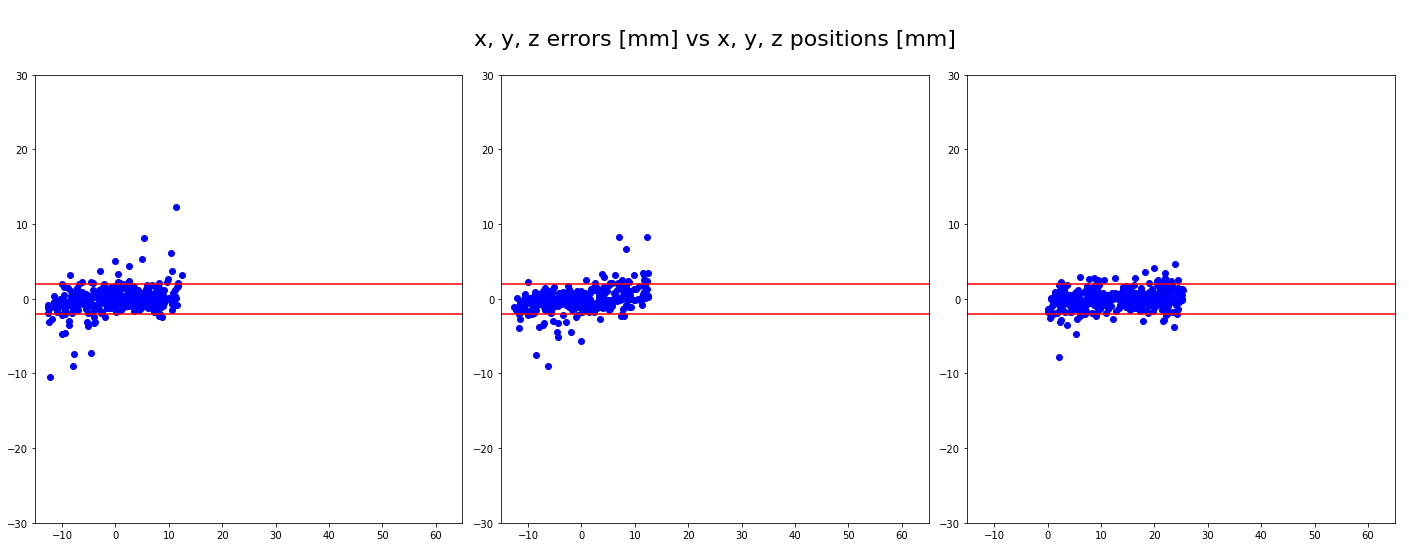

In [45]:
# arrival times: test data with known (random) solutions
answers = np.ones([8,])
for i in range(1000):
    rng = np.random.default_rng()
    r_test = rng.random((3,))
    r_test[0] = (r_test[0] - 0.5)*(25.4)
    r_test[1] = (r_test[1] - 0.5)*(25.4)
    r_test[2] *= (25.4*2)
    tt_norm = np.sqrt((Xi-r_test[0])**2+(Yi-r_test[1])**2+(Zi-r_test[2])**2)/Vp
    picks = tt_norm - np.min(tt_norm)

    # add random error (up to 1/2 a microsec) to picks
    err_picks = (rng.random((10,))-0.5)
    picks+=err_picks
    # arrival times: real data
#     picks = np.array([np.NaN, 0.0074, 0.0074, 0.0094, 0.0086, 0.0088, -0.001, np.NaN, 0.0126, 0.0092]) # sen8=0.0204
#     picks *= 1e3
#     picks = picks - np.nanmin(picks)
    
    # initial guess located in the middle of sample
    ev0 = np.array([picks.min(),np.mean([np.min(Xi),np.max(Xi)]),
                    np.mean([np.min(Yi),np.max(Yi)]),
                    np.mean([np.min(Zi),np.max(Zi)])])

    # subset of sensors, picks
    mask = np.ones(10, dtype=bool)
    mask[[0,2,4,6,8]] = False
    good_sensors = sensors[mask==True]
    good_picks = picks[mask==True]
    
    if r_test[2] <=25.4:
        # Nelder Mead optimum search (Simplex Method)
        event = fmin(err,ev0,args=(good_sensors,Vp,good_picks),disp=False,full_output=True,maxiter=1000,maxfun=1000)
        if (event[0][1]**2 + event[0][2]**2) <= Diameter**2/4:
            if event[0][3] >= np.min(Zi) and event[0][3] <= np.max(Zi):
                answers = ( np.vstack((answers,np.append(np.hstack(
                    (r_test,r_test-event[0][1:])),[event[0][0],event[4]]))) )
answers = np.delete(answers, (0), axis=0)

%matplotlib inline
fig, axs = plt.subplots(1, 3, figsize = (20, 8))
truth = answers[:,0:3]
errors = answers[:,3:6]
flag = answers[:,7]
for r,c in enumerate(errors.T):
    axs[r].plot(c, 'bo')
    axs[r].set_ylim(-55,55)
    axs[r].set_xlim(0,1000)
    axs[r].plot([-100,1100],[2,2], color = "red")
    axs[r].plot([-100,1100],[-2,-2], color = "red")
    axs[r].plot(flag.T, color = "green")
fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.title('\nError [mm] for x, y, z\n', fontsize=22)
plt.tight_layout()
plt.savefig('error_5pointsensors,RandomPickingErrorsPt5usBottomHalfSample.png')
plt.show()

# dx vs x, dy vs y, dz vs z
fig, axs = plt.subplots(1, 3, figsize = (20, 8))
for r,c in enumerate(truth.T):
    axs[r].plot(c,errors.T[r], 'bo')
    axs[r].set_ylim(-30,30)
    axs[r].set_xlim(-15,65)
    axs[r].plot([-100,1100],[2,2], color = "red")
    axs[r].plot([-100,1100],[-2,-2], color = "red")
fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.title('\nx, y, z errors [mm] vs x, y, z positions [mm]\n', fontsize=22)
plt.tight_layout()
plt.savefig('errors_5pointsensors,RandomPickingErrorsPt5usBottomHalfSample.png')
plt.show()

# check randomness of event locations in 3d
# from mpl_toolkits import mplot3d
# import matplotlib.pyplot as plt
# %matplotlib notebook
# fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax.scatter3D(truth.T[0],truth.T[1],truth.T[2])
# plt.show()

standard error =  0.09339380671574668 

(-1.8356976342698605, 1.6201710105069766)


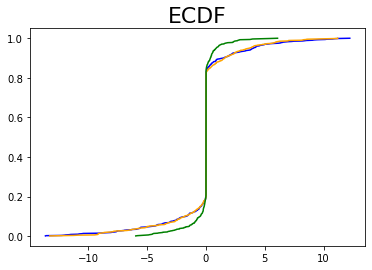

P(-2<x<2): 0.818
P(-2<y<2): 0.817
P(-2<z<2): 0.938


Text(0, 0.5, 'Count')

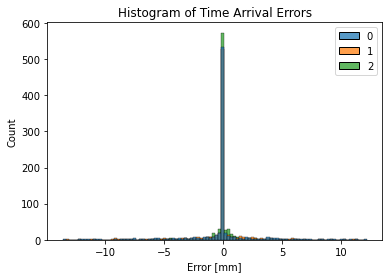

In [31]:
from scipy import stats as st
import statsmodels.stats.api as sms
from statsmodels.distributions.empirical_distribution import ECDF
import seaborn as sns

print('standard error = ',st.sem(errors.T[0]),'\n')
print(st.norm.interval(0.916, loc=np.mean(errors.T[0])))#, scale=st.sem(errors.T[0])))

Xecdf = ECDF(errors.T[0])
Yecdf = ECDF(errors.T[1])
Zecdf = ECDF(errors.T[2])

plt.plot(Xecdf.x, Xecdf.y,color='blue')
plt.plot(Yecdf.x, Yecdf.y,color='orange')
plt.plot(Zecdf.x, Zecdf.y,color='green')
plt.title('ECDF', fontsize=22)
plt.show()

print('P(-2<x<2): %.3f' % (Xecdf(2)-Xecdf(-2)))
print('P(-2<y<2): %.3f' % (Yecdf(2)-Yecdf(-2)))
print('P(-2<z<2): %.3f' % (Zecdf(2)-Zecdf(-2)))

g = sns.histplot(data=errors, bins=100)
g.set_title('Histogram of Time Arrival Errors')
g.set_xlabel('Error [mm]')
g.set_ylabel('Count')



In [11]:
# space derivative of error function ('xyz' is 0, 1, or 2 for x, y, or z)
def sp_deriv(xyz,ev,r,v,at):
    presum_result = []
    for ri in r:
        val = 2*(atf(ev,r,v)-at)*(ri[xyz]-ev[xyz+1])/v/np.sqrt((ev[1]-ri[0])**2+(ev[2]-ri[1])**2+(ev[3]-ri[2])**2)
        presum_result.append(val)
    result = np.array(presum_result).sum()
    return result

# time derivative of error function
def t_deriv(ev,r,v,at):
    return (2*(atf(ev,r,v)-at)).sum()
          
def gradient_descent(err,ev0,r,v,at,step_size=0.0001,n_iter=1000):
    # generate an initial point
    ev = ev0
    # run the gradient descent
    for i in range(n_iter):
        # calculate gradient
        gradt = t_deriv(ev,r,v,at)
        gradx = sp_deriv(0,ev,r,v,at)
        grady = sp_deriv(1,ev,r,v,at)
        gradz = sp_deriv(2,ev,r,v,at)
        # take a step
        ev[0] = ev[0]-step_size*gradt
        ev[1] = ev[1]-step_size*gradx
        ev[2] = ev[2]-step_size*grady
        ev[3] = ev[3]-step_size*gradz
        # evaluate candidate point
        solution_eval = err(ev,r,v,at)
        # report progress
        #print('>%d f = %.5f' % (i, solution_eval))
    return ev,n_iter

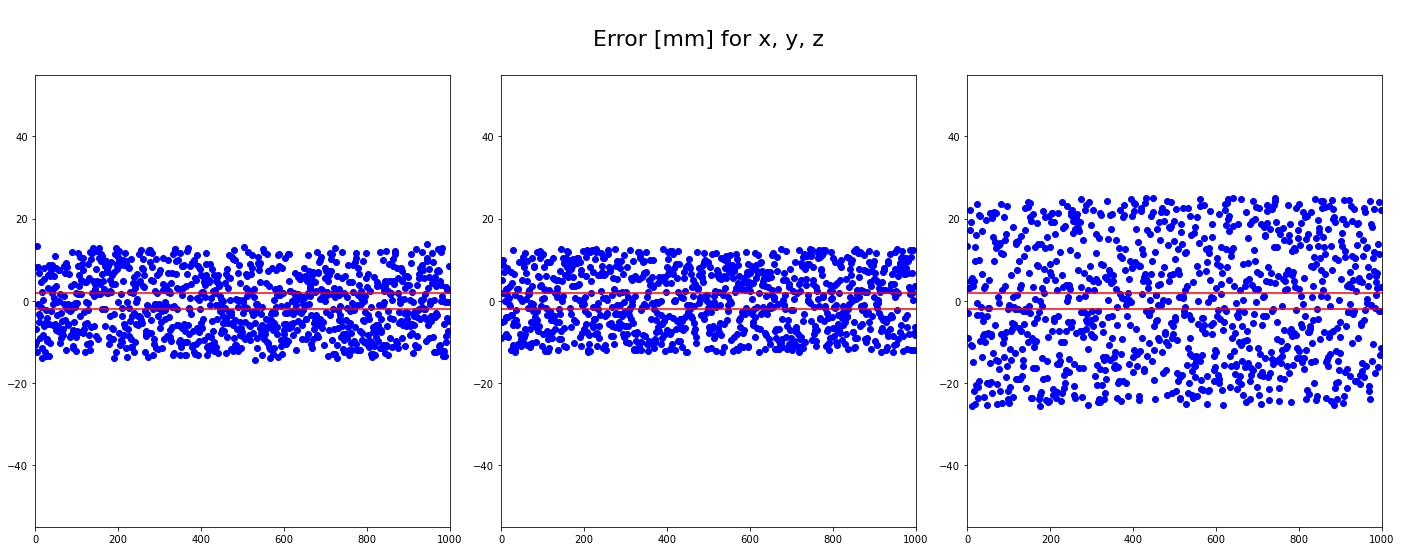

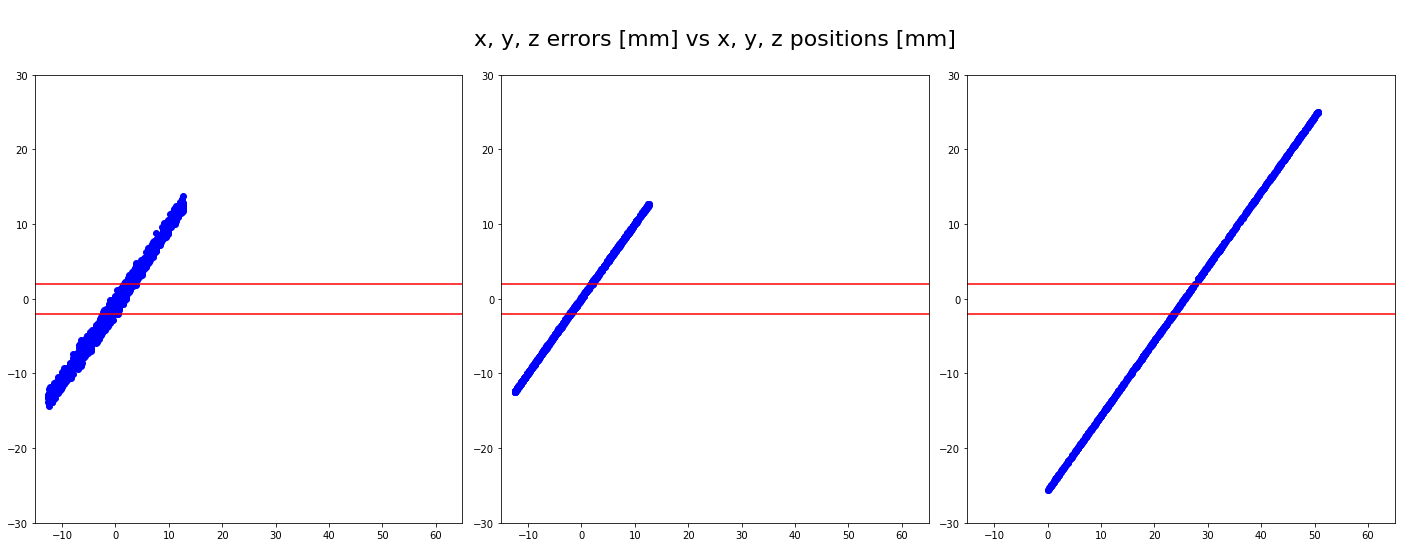

In [12]:
# arrival times: test data with known (random) solutions
answers = np.ones([8,])
for i in range(1000):
    rng = np.random.default_rng()
    r_test = rng.random((3,))
    r_test[0] = (r_test[0] - 0.5)*(25.4)
    r_test[1] = (r_test[1] - 0.5)*(25.4)
    r_test[2] *= (25.4*2)
    tt_norm = np.sqrt((Xi-r_test[0])**2+(Yi-r_test[1])**2+(Zi-r_test[2])**2)/Vp
    picks = tt_norm - np.min(tt_norm)

    # arrival times: real data
#     picks = np.array([np.NaN, 0.0074, 0.0074, 0.0094, 0.0086, 0.0088, -0.001, np.NaN, 0.0126, 0.0092]) # sen8=0.0204
#     picks *= 1e3
#     picks = picks - np.nanmin(picks)
    
    # initial guess located in the middle of sensors
    ev0 = np.array([picks.min(),np.mean([np.min(Xi),np.max(Xi)]),
                    np.mean([np.min(Yi),np.max(Yi)]),
                    np.mean([np.min(Zi),np.max(Zi)])])
    # or, initial guess = true answers
    #ev0[1:3] = r_test[0:2]
    
    # subset of sensors, picks
    mask = np.ones(10, dtype=bool)
    # pick a few 'bad' sensors here, if desired
    mask[[0,1,2,7]] = False
    good_sensors = sensors[mask==True]
    good_picks = picks[mask==True]
    
    # Gradient Descent
    event,N = gradient_descent(err,ev0,good_sensors,Vp,good_picks,step_size=0.01,n_iter=100)
    # make sure location is within bounds of sample
    if event[1] > np.min(Xi) and event[1] < np.max(Xi):
        if event[2] > np.min(Yi) and event[2] < np.max(Yi):
            if event[3] > np.min(Zi) and event[3] < np.max(Zi):
                #answers = np.vstack((answers,np.append(event,[N,r])))
                answers = ( np.vstack((answers,np.append(np.hstack(
                    (r_test,r_test-event[1:])),[event[0],N]))) )
                
# remove first row placeholder
answers = np.delete(answers, (0), axis=0)

%matplotlib inline
fig, axs = plt.subplots(1, 3, figsize = (20, 8))
truth = answers[:,0:3]
errors = answers[:,3:6]
flag = answers[:,7]
for r,c in enumerate(errors.T):
    axs[r].plot(c, 'bo')
    axs[r].set_ylim(-55,55)
    axs[r].set_xlim(0,1000)
    axs[r].plot([-100,1100],[2,2], color = "red")
    axs[r].plot([-100,1100],[-2,-2], color = "red")
    axs[r].plot(flag.T, color = "green")
fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.title('\nError [mm] for x, y, z\n', fontsize=22)
plt.tight_layout()
plt.show()

# dx vs x, dy vs y, dz vs z
fig, axs = plt.subplots(1, 3, figsize = (20, 8))
for r,c in enumerate(truth.T):
    axs[r].plot(c,errors.T[r], 'bo')
    axs[r].set_ylim(-30,30)
    axs[r].set_xlim(-15,65)
    axs[r].plot([-100,1100],[2,2], color = "red")
    axs[r].plot([-100,1100],[-2,-2], color = "red")
fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.title('\nx, y, z errors [mm] vs x, y, z positions [mm]\n', fontsize=22)
plt.tight_layout()
plt.show()

# check randomness of event locations in 3d
# from mpl_toolkits import mplot3d
# import matplotlib.pyplot as plt
# %matplotlib notebook
# fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax.scatter3D(truth.T[0],truth.T[1],truth.T[2])
# plt.show()